# Spike sorting with RMM

In [ ]:
# SALVARE PLOT CON NOME CHANNEL

In [ ]:
import glob
list_dir=glob.glob("/Users/Gaia_1/Desktop/allh5filestutto/*.h5")
for file in list_dir:
    print(file)
print(len(list_dir))

In [ ]:
#final_neurons=[]
final_firing=[]
from NewLibraryENGcopia import *
import glob
#final=[]
list_dir=glob.glob("/Users/Gaia_1/Desktop/allh5filestutto/*.h5")
output_path='/Users/Gaia_1/Desktop/tesi/Data after SS 28feb'
n_healthy_bl=0
n_healthy_st=0
n_lrrk2_bl=0
n_lrrk2_st=0
for file in tqdm(list_dir):
    target=1
    stim=0
    if 'health' in file:
        target=0
    if 'after' in file:
        stim=1
    file_name = file.split("/")[-1]

    if target==0 and stim==0:
        name=f"healthy_bl_{n_healthy_bl}"
        n_healthy_bl+=1
    
    if target==0 and stim==1:
        name=f"healthy_st_{n_healthy_st}"
        n_healthy_st+=1
    
    if target==1 and stim==0:
        name=f"lrrk2_bl_{n_lrrk2_bl}"
        n_lrrk2_bl+=1
    
    if target==1 and stim==1:
        name=f"lrrk2_st_{n_lrrk2_st}"
        n_lrrk2_st+=1
    
    print(name,':','target',target,'stimulation',stim)
    neurons,firing=this_spike_sorting(file,output_path,name)
    #final_neurons.append(neurons)
    final_firing.append(firing)
    #print(firing)

HEALTHY BL mean =  18.58737936094091
HEALTHY AFTER mean =  28.297702249737675
LRRK2 BL mean =  7.975298302879738
LRRK2 AFTER mean =  5.7064225506471145


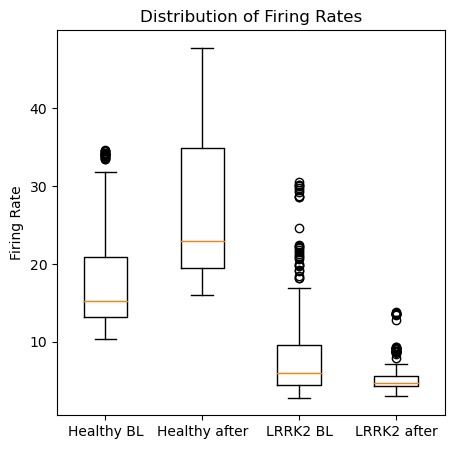

In [27]:
import matplotlib.pyplot as plt

# Initialize lists to store numerical values
healthy_values_BL = []
healthy_values_af = []

lrrk2_values_BL = []
lrrk2_values_af = []

# Iterate through the list of lists
for firing in final_firing:
    file_name = firing[0]
    numerical_values = [float(arr[0]) for arr in firing[1:]]
    
    # Check if the file name contains 'after'
    if 'healthy' in file_name:
        if 'after' in file_name:
            healthy_values_af.extend(numerical_values)
        else:
            healthy_values_BL.extend(numerical_values)
    else:
        if 'after' in file_name:
            lrrk2_values_af.extend(numerical_values)
        else:
            lrrk2_values_BL.extend(numerical_values)
print('HEALTHY BL mean = ', np.mean(healthy_values_BL))
print('HEALTHY AFTER mean = ', np.mean(healthy_values_af))
print('LRRK2 BL mean = ', np.mean(lrrk2_values_BL))
print('LRRK2 AFTER mean = ', np.mean(lrrk2_values_af))
# Create box plots for each group
plt.figure(figsize=(5, 5))
plt.boxplot([healthy_values_BL,healthy_values_af, lrrk2_values_BL, lrrk2_values_af], labels=['Healthy BL','Healthy after', 'LRRK2 BL','LRRK2 after'])
plt.title('Distribution of Firing Rates')
plt.ylabel('Firing Rate')
#plt.savefig('firing_rates_boxplot_28feb.jpg')
plt.show()


# Functions

In [ ]:
file_names = [firing[0] for firing in final_firing]
numerical_values = [[float(arr[0]) for arr in firing[1:]] for firing in final_firing]

# Save the file names and numerical values to a text file
output_path = "/Users/Gaia_1/Desktop"
with open(f"{output_path}/firings.txt", "w") as file:
    for file_name, values in zip(file_names, numerical_values):
        file.write(f"{file_name}: {', '.join(map(str, values))}\n")

In [18]:
def this_spike_sorting(input_path,output_path,savename):
    name_data = input_path.split("/")[-1]
    #file reading:
    print('File Reading...')
    data = h5py.File(input_path,'r')
    data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
    info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
    info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
    labels = info_table['Label']
    readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
    fs = 10000 #Sampling Frequency
    print('data shape: ',readings.shape)
    prova=readings.drop([b'Ref'],axis=1)
    #prova=prova.iloc[0:750500, :]
    #prova=prova.iloc[:, :15]
    ref=readings[b'Ref']
    #ref=ref[0:750500]
    freqs, spectrogram = signal.welch(readings[b'Ref'].values, fs=10000, nfft=1024)
    noise_freq = freqs[spectrogram.argmax()]
    Q = 30
    b, a = scipy.signal.iirnotch(noise_freq, Q, fs)
    Q = 60
    b_2, a_2 = scipy.signal.iirnotch(2*noise_freq, Q, fs)
    channel = readings[b'Ref'].values
    pre_filtered_ref = scipy.signal.filtfilt(b, a, channel)
    pre_filtered_ref = scipy.signal.filtfilt(b_2, a_2, pre_filtered_ref) 
    ref=pre_filtered_ref

    #filtering:
    prova_rows = range(prova.shape[0])
    filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
    lowcut = 300
    highcut = 3000
    fs=10000
    order=8
    b,a=butter_bandpass(lowcut,highcut,fs,order=order)
    filt_ref=filtfilt(b,a,ref)
    print('Data Filtering:')
    for x in tqdm(range(prova.shape[1])):
        filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
    for electrode in prova.columns:
        filt_prova[electrode] = filt_prova[electrode] - filt_ref
    prova=filt_prova
    #detection:
    all_ind=[]
    print('Spike Detection: ')
    for i,electrode in enumerate(tqdm(prova.columns)):
        channel=prova[electrode]
        #ind=windowed_spike_detection(channel)
        ind=this_spike_detection(channel)
        all_ind.append(ind)
    #spike extraction:
    cut_outs=[]
    all_new=[]
    print('Spike extraction: ')
    for i,electrode in enumerate(tqdm(prova.columns)):
        ind=all_ind[i]
        channel=prova[electrode]
        cut_outs1,all_new1=spike_extraction(ind,channel)
        cut_outs.append(cut_outs1)
        all_new.append(all_new1)    
    # Clustering:
    final_data=[]
    final_firing=[]
    final_firing.append(name_data)
    print('Clustering: ')
    for channel in (tqdm(range(len(cut_outs)))):
        channel_clusters1,final_firing1=this_clus(cut_outs[channel],all_new[channel],prova.iloc[:,channel],savename)
        final_data.append(channel_clusters1)
        final_firing.append(final_firing1)
    neurons=[]
    for channel in final_data:
        for neuron in channel:
            neurons.append(neuron)
    print(len(neurons),' neurons detected and sorted')
    adj_neur=[]
    counter = 0
    max_len=0
    for neuron in neurons:
        print('counter: ',counter,neuron.shape[0])
        if neuron.shape[0]>max_len:
            max_len=neuron.shape[0]
        counter+=1
    for neuron in neurons:
        if neuron.shape[0]<max_len:
            diff = max_len-neuron.shape[0]
            adj_neur.append(np.concatenate((neuron,np.zeros([diff]))))
    save_data = 'After'+name_data+'.txt'
    #np.savetxt("/Users/Gaia_1/Desktop/tesi/Data after SS/%s.txt" % save_data,adj_neur, delimiter=', ', fmt='%12.8f')
    np.savetxt(f"{output_path}/{save_data}.txt", adj_neur, delimiter=', ', fmt='%12.8f')

    print('saved: ',save_data)
    return neurons, final_firing


In [13]:
def this_spike_detection(data):
    spike_length=30 #3ms (0.003s)
    window_length=600000 #60 sec (1min)
    neg_data=-(data)
    abs_data=abs(data)
    i=0
    ind=[]
    while i < len(data)-window_length:
        neg_window=neg_data[i:i+window_length]
        abs_window=abs_data[i:i+window_length]
        window=data[i:i+window_length]
        #coeff=4
        #if abso==0:
        coeff=3
        thresh=coeff*(scipy.stats.median_abs_deviation(window,scale='normal'))
        #else:
            #coeff=4
            #thresh=coeff*(scipy.stats.median_abs_deviation(abs_window,scale='normal'))
        ind1, peaks =find_peaks(neg_window, height=thresh,distance=spike_length)
        del peaks
        last=i
        if len(ind1):
            last=i+ind1[-1]
        ind.extend([index + i for index in ind1])
        i=last+spike_length #0.003 s (30ms)
    firing_rate=len(ind)*10000/len(data)
    print(len(ind), ' spikes detected;  ', 'firing rate: {:.2f}'.format(firing_rate),'Hz')
    return ind


In [22]:
def spike_extraction(alls,data):
        pre = 0.001
        post = 0.002
        fs=10000
        prima = int(pre*fs)
        dopo = int(post*fs)
        lunghezza_indici = len(alls)
        cut= np.empty([lunghezza_indici, prima+dopo])
        dim = data.shape[0]
        k=0
        #coeff=2
        signal_std=np.std(data)
        signal_mean=np.mean(data)
        standard_mean=signal_mean
        standard_threshold=signal_std
        for i in alls:
            if (i-prima >= 0) and (i+dopo <= dim):
                spike= data[(int(i)-prima):(int(i)+dopo)].squeeze()
                cut[k,:] = spike
                k+=1
        standards=np.std(cut,axis=1)
        means=np.mean(cut,axis=1)
    
        thr1=2*standard_threshold
        thr2=3*standard_mean
    
        indices=np.where((standards<thr1)&(means<thr2))[0]
    
        filtered_alls = np.array(alls)[indices]
        filtered_cut=cut[indices]
        
        spike_means=np.mean(filtered_cut,axis=1,keepdims=True)
        spike_stds=np.std(filtered_cut,axis=1,keepdims=True)
        spike_stds[spike_stds == 0] = 1

        standardized_cuts=(filtered_cut-spike_means)/spike_stds
        
        firing_rate=len(indices)*10000/len(data)
        print(len(alls)-len(indices),' spikes removed;  ', 'firing rate: {:.2f}'.format(firing_rate),'Hz')
        return standardized_cuts,filtered_alls

def cut_all(alls,data):
    pre = 0.001
    post = 0.002
    fs=10000
    prima = int(pre*fs)
    dopo = int(post*fs)
    lunghezza_indici = len(alls)
    cut= np.empty([lunghezza_indici, prima+dopo])
    dim = data.shape[0]
    k=0
    coeff=1.5
    signal_std=np.std(data)
    signal_mean=np.mean(data)
    standard_mean=signal_mean
    standard_threshold=signal_std
    for i in alls:
        if (i-prima >= 0) and (i+dopo <= dim):
            spike= data[(int(i)-prima):(int(i)+dopo)].squeeze()
            cut[k,:] = spike
            k+=1
    standards=np.std(cut,axis=1)
    means=np.mean(cut,axis=1)

    thr1=coeff*standard_threshold
    thr2=coeff*standard_mean
    
    indices=np.where((standards<thr1)&(means<thr2))[0]

    filtered_alls = np.array(alls)[indices]
    filtered_cut=cut[indices]
    
    spike_means=np.mean(filtered_cut,axis=1,keepdims=True)
    spike_stds=np.std(filtered_cut,axis=1,keepdims=True)
    
    standardized_cuts=(filtered_cut-spike_means)/spike_stds
    
    firing_rate=len(indices)*10000/len(data)
    print(len(alls)-len(indices),' spikes removed;  ', 'firing rate: {:.2f}'.format(firing_rate),'Hz')
    return standardized_cuts,filtered_alls


In [15]:
def this_clus(cut,spike_list,data,name):
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.metrics import silhouette_score
    import numpy as np
    save_folder = "/Users/Gaia_1/Desktop/tesi/clustering/"
    scale = StandardScaler()
    estratti_norm = scale.fit_transform(cut)
    print('\n______________________________________________________________________________________________________________')
    print('Total spikes: ', estratti_norm.shape[0])
    n_comp=3
    pca = PCA(n_components=n_comp)
    transformed = pca.fit_transform(estratti_norm)
    spike_list=np.array(spike_list)
    kmeans_score=[]
    final_data=[]
    final_firing=[]
    for n in range (2,4):
        model = KMeans(n_clusters=n, init='k-means++', n_init=10, max_iter=400, tol=0.25, verbose=0, random_state=None, copy_x=True,  algorithm='lloyd')
        labels = model.fit_predict(transformed)
        silhouette_avg = silhouette_score(transformed, labels)
        kmeans_score.append(silhouette_avg)
    top_clusters_kmeans = kmeans_score.index(max(kmeans_score))+2
    if max(kmeans_score)>=0.4:
        print("\n\n\033[1;31;47mBest cluster in the range 1 to 3: ",top_clusters_kmeans,", with a silhouette score of: ",max(kmeans_score), "\u001b[0m  \n\n")
        model = KMeans(n_clusters=top_clusters_kmeans,  init='k-means++', n_init=10, max_iter=400, tol=0.25, verbose=0, random_state=None, copy_x=True,  algorithm='lloyd')
        labels = model.fit_predict(transformed)
    else:
        print('Clustering algorithm detected only one cluster')
        labels=np.zeros(len(spike_list),dtype=int)
    unique_labels=np.unique(labels)
    firings=np.zeros(len(unique_labels))
    color=[]
    for i in labels:
        color.append(plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    for i,cluster_label in enumerate(unique_labels):
        cluster_data=cut[labels==cluster_label]
        mean_wave=np.mean(cluster_data, axis=0)
        std_wave=np.std(cluster_data, axis=0)
        
        filtered_cluster_data=cluster_data
        
        plotting_data=filtered_cluster_data.transpose()
        
        firings[i]=len(filtered_cluster_data)*10000/len(data)
        
        fig = plt.figure(figsize=(8,10))
        
        plt.subplot(3,1,i+1)
        plt.plot(plotting_data,alpha=0.5)
        
        plt.title(f'Cluster {i} \n numerosity: {len(filtered_cluster_data)}')
        plt.xlabel('Time [ms]')
        plt.ylabel('Signal Amplitude')
        mean_wave = np.mean(filtered_cluster_data, axis=0)
        std_wave = np.std(filtered_cluster_data, axis=0)
        plt.errorbar(range(mean_wave.shape[0]), mean_wave, yerr=std_wave, color='blue', linewidth=2, label='Avg. Waveform')
        plt.legend(loc='lower right')
        plt.savefig(f'{save_folder}Cluster{i}_{name}')
        plt.show()
        ul=spike_list[labels==i]
        ull=ul
        #ull=ul[indices_to_keep]
        final_data.append(ull)
        final_firing.append(firings)
        plt.subplot(3, 1, i + 1)
        plt.hist(np.diff(ull), bins=100, density=True, alpha=0.5, color='blue', edgecolor='black')
        plt.title(f'ISI: Cluster {i}, \n firing rate: {format(len(final_data[i])*10000/len(data), ".2f")} Hz')
        plt.savefig(f'{save_folder}ISI_Cluster{i}_{name}')
        plt.show()
        
    return final_data, final_firing
